# Analyse the user annotation

load the ovaries_binary_matrix file and wisualise some infomation

In [1]:
%matplotlib inline
import os, re, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [2]:
PATH_BASE = '../'
PATH_CSV_GENE_MATRIX = PATH_BASE + 'data_images/ovaries_binary_matrix.csv'
PATH_TXT_IMAGES = PATH_BASE + 'data_images/all_ovary_image_info_for_prague.txt'
PATH_CSV_GENE_MATRIX_EXT = PATH_BASE + 'results/ovaries_binary_matrix.csv'
PATH_CSV_IMAGES_GENE = PATH_BASE + 'results/all_ovary_image_info_gene_binary_matrix.csv'
# PATH_CSV_IMAGES_GENE_SHORT = 'results/all_ovary_image_info_gene_binary_matrix_short.csv'
# PATH_CSV_LOCATIONS = 'temporary/ovaries_locations.csv'

## Loading the csv with gene location matrix

In [3]:
df_gene = pd.read_csv(PATH_CSV_GENE_MATRIX)
print ('loaded records: %i with columns: %i' % (len(df_gene), len(df_gene.columns)))
print ('-> %s', df_gene.columns.tolist()[:10])
# print 'unique indexes:', len(df_gene.groupby(df_gene.index).first())

loaded records: 7895 with columns: 137
-> %s ['Gene ID', 'Flybase ID', 'Flybase name', 'Plate', 'pos', '1:2:stage1', '2:3:stage2_to_7', '3:4:stage8', '4:5:stage9', '5:6:stage10']


In [4]:
cols = [re.sub(':\d+:', ':', c).replace('_', '') for c in df_gene.columns]
cols2 = [re.sub('\d+:\d+:', '', c).replace('_', ' ') for c in df_gene.columns]
print ('sizes: %i -> %i -> %i' % (len(df_gene.columns), len(set(cols)), len(set(cols2))))
# print ('ALL:', sorted(set(cols)))
TAGS = ['ubiquitous', 'follicle cell', 'border cell', 'nurse cell', 'germline cell', 'somatic cell']
for tag in TAGS:
    print ('Tag: %s >> %s' % (tag, repr([n for n in set(cols2) if tag in n])))

sizes: 137 -> 123 -> 53
Tag: ubiquitous >> ['enrichment ubiquitous', 'follicle cells ubiquitous', 'germline cells ubiquitous', 'ubiquitous signal', 'ubiquitous signal at all stages', 'nurse cells ubiquitous', 'oocyte ubiquitous']
Tag: follicle cell >> ['follicle cells overlaying the oocyte', 'anterior follicle cells', 'follicle cells ubiquitous', 'centripetally migrating follicle cells', 'squamous follicle cells', 'anterior follicle cell', 'follicle cells', 'posterior follicle cells']
Tag: border cell >> ['border cells']
Tag: nurse cell >> ['nurse cells', 'nurse cells nuclear foci', 'presumptive nurse cells', 'nurse cells perinuclear', 'nurse cells ubiquitous']
Tag: germline cell >> ['germline cells ubiquitous', 'germline cells']
Tag: somatic cell >> ['somatic cells']


remove a mubering from middle of the each column name

In [5]:
# df_gene.columns = [re.sub(':\d+:', ':', c) for c in df_gene.columns]
# df_gene.head()

duplicate colums with "all stages" to such colmns

In [6]:
df_gene.columns = [c.replace('_', ' ') for c in df_gene.columns]
for c in (c for c in df_gene.columns if 'at all stages' in c):
    c_base = c.replace('at all stages', '').rstrip()
    for sg in range(6):
        df_gene[str(sg) + c_base[1:]] = df_gene[c]
    del df_gene[c]

In [7]:
# the identification of key columns
COL_HEAD = ['Gene ID', 'Flybase ID', 'Flybase name', 'Plate', 'pos']
# cleaned lost of columns
COL_LABEL = [c for c in df_gene.columns 
             if c not in COL_HEAD and re.match('\d+:', c) 
             and all(ci not in c for ci in [':stage', 'at all stages', 'misc'])]
# unique columns labels
COL_LABEL_UQ = list(set([re.sub('\d+:\d+:', '', c).replace('cells', 'cell') for c in COL_LABEL]))
print (COL_LABEL_UQ)

['escort cell', 'nurse cell ubiquitous', 'nurse cell perinuclear', 'terminal filament', 'cortical enrichment', 'cap cell', 'posterior follicle cell', 'squamous follicle cell', 'germline cell ubiquitous', 'germline cell', 'enrichment ubiquitous', 'anterior restriction', 'interesting pattern', 'germline stem cell', 'apical restriction', 'presumptive nurse cell', 'border cell', 'follicle cell', 'follicle stem cell', 'nuclear foci', 'perinuclear', 'nurse cell nuclear foci', 'presumptive oocyte', 'follicle cell overlaying the oocyte', 'interfollicular stalk cell', 'ubiquitous signal', 'anterior follicle cell', 'follicle cell ubiquitous', 'oocyte nucleus', 'oocyte ubiquitous', 'basal restrictrion', 'centripetally migrating follicle cell', 'no signal', 'somatic cell', 'oocyte', 'cytoplasmic foci', 'posterior restriction', 'cystoblast', 'nurse cell']


transform the label matrix -> all posibla labels over all stages and have stage as a parameters

In [8]:
def parse_row(idx_row):
    idx, row = idx_row
    rrow = dict(row[COL_HEAD])
    # iterate over all stages 1, ..., 5
    r_gene = []
    for sg in range(1, 6):
        rrow_l = rrow.copy()
        rrow_l['stage'] = sg
        for l_uq in COL_LABEL_UQ:
            # agregate over all colums with the unique column name
            ll = [l for l in COL_LABEL if re.match(str(sg) + ':\d+:' + l_uq, l)]
            val = max(row[ll]) if len(ll) > 0 else 0
            rrow_l[l_uq] = val
        r_gene.append(rrow_l)
    return r_gene

In [9]:
l_gene = []
for idx, row in tqdm.tqdm(df_gene.iterrows(), desc='parse gene rows'):
    l_gene += parse_row([idx, row])
    
# import bpdl.utilities as utils
# l_gene = []
# for r_gene in utils.wrap_execute_sequence(parse_row, df_gene.iterrows(), nb_workers=4, desc='parse gene rows'):
#     l_gene += parse_row([idx, row])

# create the DF
df_gene_ext = pd.DataFrame(l_gene)
df_gene_ext.to_csv(PATH_CSV_GENE_MATRIX_EXT, index=False)
# df_gene_ext.head()

parse gene rows: 7895it [10:24, 12.64it/s]


## Genes appers in particular stages

In [10]:
df_gene_ext = pd.read_csv(PATH_CSV_GENE_MATRIX_EXT, index_col=None)
l_stat = []
for sg, dfg in df_gene_ext.groupby('stage'):
    stat = dict(dfg.sum())
    stat['stage'] = sg
    l_stat.append(stat)
df_stat = pd.DataFrame(l_stat).set_index('stage')
df_stat.to_csv('temp-statistic_oavry-label.csv')
del df_stat['pos']

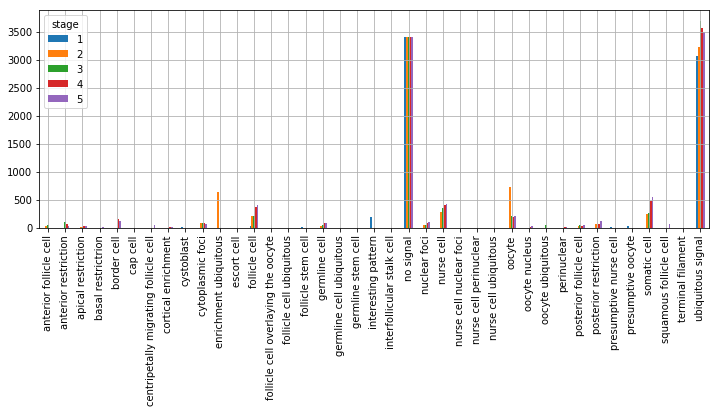

In [11]:
_= df_stat.T.plot.bar(figsize=(12, 4), grid=True)

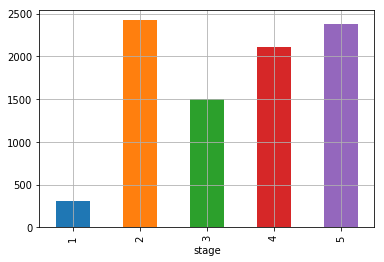

In [12]:
df_stat_sr = df_stat.copy()
del df_stat_sr['no signal']
del df_stat_sr['ubiquitous signal']
_= df_stat_sr.T.sum().plot.bar(figsize=(6, 4), grid=True)

In [13]:
df_gene_ext = pd.read_csv(PATH_CSV_GENE_MATRIX_EXT, index_col=None)
TAGS = ['follicle cell', 'border cell', 'nurse cell', 'germline cell', 'somatic cell']
l_stat = []
for sg, dfg in df_gene_ext.groupby('stage'):
    stat = {'stage': sg}
    for tag in TAGS:
        ll = [c for c in df_gene_ext.columns if tag in c]
        stat[tag] = np.sum(dfg[ll].sum())
    l_stat.append(stat)
df_stat_tag = pd.DataFrame(l_stat).set_index('stage')
df_stat_tag.to_csv('temp-statistic2_oavry-label.csv')

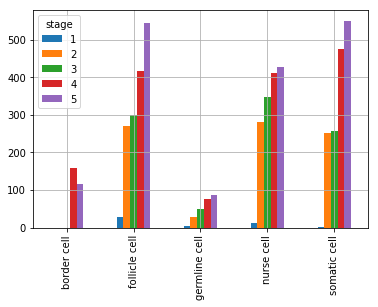

In [14]:
_= df_stat_tag.T.plot.bar(figsize=(6, 4), grid=True)

## Loading the txt file with all imges and used genes

In [15]:
df_images = pd.read_csv(PATH_TXT_IMAGES, sep='\t')
# df_images['id'] = df_images.index
# df_images.reset_index(drop=True, inplace=True)
print ('loaded records: %i with columns:\n %s' % (len(df_images), df_images.columns.tolist()))

loaded records: 34282 with columns:
 ['id', 'est_id', 'gene_id', 'fbgn', 'cgname', 'stage', 'image_id', 'image_path', 'ant_x', 'ant_y', 'post_x', 'post_y', 'lat_x', 'lat_y', 'slice_index', 'stack_path']


In [16]:
df_images.head(3)

,id,est_id,gene_id,fbgn,cgname,stage,image_id,image_path,ant_x,ant_y,post_x,post_y,lat_x,lat_y,slice_index,stack_path
0,448,LD17129-dg,CG6605,FBgn0000183,CG6605,1,1,insitu1.tif,193,935,452,587,236,720,19,MD-Experiment-2011-04-15-11971_Position(23).zvi
1,448,LD17129-dg,CG6605,FBgn0000183,CG6605,1,2,insitu2.tif,367,798,606,882,509,799,28,MD-Experiment-2011-04-15-11971_Position(20).zvi
2,448,LD17129-dg,CG6605,FBgn0000183,CG6605,1,3,insitu3.tif,305,990,396,801,293,864,22,MD-Experiment-2011-04-15-11971_Position(6).zvi


## Fuse those two tables together

In [17]:
df_gene_ext['Plate'] = [v.replace('.', '') for v in df_gene_ext['Plate']]
df_images['Plate'] = [re.split('[ _\-]+', v)[0] for v in df_images['stack_path']]

In [18]:
COLS_IMAGES = ['stage', 'fbgn', 'cgname', 'Plate']
print ('uq. images rows: %i' % len(df_images.drop_duplicates(COLS_IMAGES)))
COLS_GENE = ['stage', 'Flybase ID', 'Gene ID', 'Plate']
print ('uq. gene rows: %i' % len(df_gene_ext.drop_duplicates(COLS_GENE)))
df_fuse = pd.merge(df_images, df_gene_ext.drop_duplicates(COLS_GENE), 
                   left_on=COLS_IMAGES, right_on=COLS_GENE, how='inner')
# df_fuse = pd.merge(df_images, df_gene_ext, 
#                    left_on=COLS_IMAGES, right_on=COLS_GENE, how='inner')
print ('Fusion %i + %i -> %i' % (len(df_images), len(df_gene_ext), len(df_fuse)))
df_fuse['label count'] = df_fuse[COL_LABEL_UQ].T.sum()
df_fuse.to_csv(PATH_CSV_IMAGES_GENE)

uq. images rows: 5376
uq. gene rows: 39405
Fusion 34282 + 39475 -> 26039


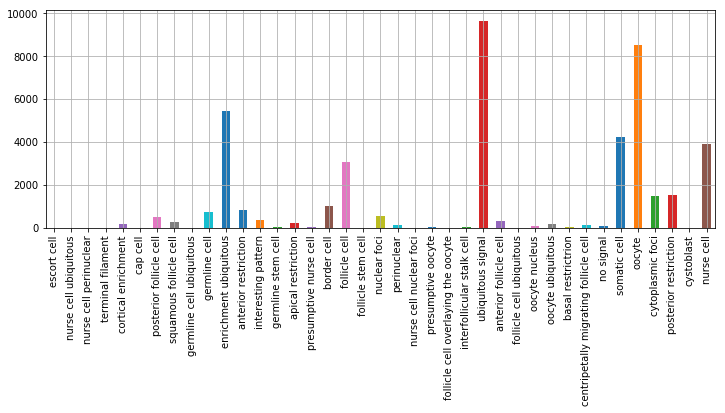

In [19]:
_= df_fuse[COL_LABEL_UQ].sum().plot.bar(figsize=(12, 4), grid=True)

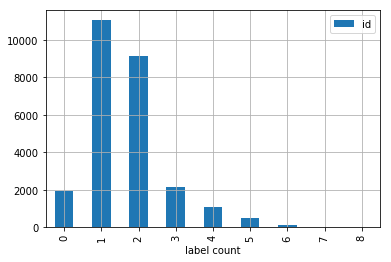

In [20]:
_= df_fuse[['label count', 'id']].groupby('label count').count().plot.bar(grid=True)

# Copy sample images grouoed by labels

In [21]:
PATH_IMAGES_IMGS = '/datagrid/Medical/microscopy/drosophila/ovary_selected_images'
PATH_IMAGES_SEGS = '/datagrid/Medical/microscopy/drosophila/RESULTS/PIPELINE_ovary_all_images/1_init_tissue_segmentation-vBFlach'

In [22]:
def compute_folder_histograms(path_imgs, df_dir_stat, path_segs=None, nb_max=None, nb_bins=50):
    d_hists = {}
    for n in tqdm.tqdm(df_dir_stat.index[:nb_max]):
        lp_images = sorted(glob.glob(os.path.join(path_imgs, n, '*')))
        if len(lp_images) == 0:
            continue
        hists = []
        for p_img in lp_images:
            im = plt.imread(p_img)[:, :, 1]
            if path_segs is None:
                seg = np.ones(im.shape)
            else:
                p_seg = os.path.join(path_segs, os.path.splitext(os.path.basename(p_img))[0] + '.png')
                if not os.path.isfile(p_seg):
                    continue
                seg = plt.imread(p_seg) > 0
            hg, b = np.histogram(im[seg > 0].ravel(), bins=nb_bins)
            hg = (hg / float(np.sum(hg)))
            hists.append(hg)
        if len(hists) > 0:
            bins = (b[1:] + b[:-1]) / 2.
            d_hists[n] = hists
    return d_hists, bins

In [46]:
def show_folder_histograms(d_hists, bins, nb_samples=50, nb_cols=4):
    nb_rows = int(np.ceil(len(d_hists) / float(nb_cols)))
    fig, axarr = plt.subplots(ncols=nb_cols, nrows=nb_rows, figsize=(nb_cols * 4, nb_rows * 2))
    for i, n in enumerate(d_hists):
        ax = axarr[int(i / nb_cols), i % nb_cols]
        ax.set_title(n), ax.grid()
        ax.semilogy(bins / np.max(bins), np.array(d_hists[n])[:nb_samples].T)
        ax.set_xlabel('gene intensity')
        # plt.xticks(range(75)[::5], [str(round(b * 255)) for b in bins[::5]])
    fig.tight_layout()

### Copy Images with single tag

In [24]:
PATH_IMAGES_OUT_1 = '/datagrid/Medical/microscopy/drosophila/TEMPORARY/annot-user-labels-1'

df_fuse_1 = df_fuse[df_fuse['label count'] == 1]
# print ('found: %i' % len(df_fuse_1))
for lb in tqdm.tqdm(COL_LABEL_UQ, desc='labels'):
    df_lb = df_fuse_1[df_fuse_1[lb] == 1]
    path_lb = os.path.join(PATH_IMAGES_OUT_1, lb)
    if not os.path.isdir(path_lb):
        os.mkdir(path_lb)
    for idx, row in df_lb.iterrows():
        p_img_in = os.path.join(PATH_IMAGES_IMGS, row['image_path'])
        p_img_out = os.path.join(path_lb, os.path.splitext(row['image_path'])[0] + '.png')
        if os.path.isfile(p_img_in) and not os.path.isfile(p_img_out):
            plt.imsave(p_img_out, plt.imread(p_img_in))
            # shutil.copy(p_img_in, p_img_out)

labels: 100%|██████████| 39/39 [00:05<00:00,  6.74it/s]


In [25]:
l_dirs = [{'label': os.path.basename(p), 'count': len(glob.glob(os.path.join(p, '*')))} 
          for p in glob.glob(os.path.join(PATH_IMAGES_OUT_1, '*')) if os.path.isdir(p)]
df_dir_stat_1 = pd.DataFrame(l_dirs).set_index('label').sort_values('count', ascending=False)
df_dir_stat_1[df_dir_stat_1['count'] > 0]

,count
label,
ubiquitous signal,8630
nurse cell,2280
interesting pattern,320
no signal,100
germline cell,84
somatic cell,42
oocyte,27
follicle cell,26
presumptive oocyte,18


In [26]:
d_hists_1, bins_1 = compute_folder_histograms(PATH_IMAGES_OUT_1, df_dir_stat_1)

100%|██████████| 39/39 [06:08<00:00,  9.44s/it]  


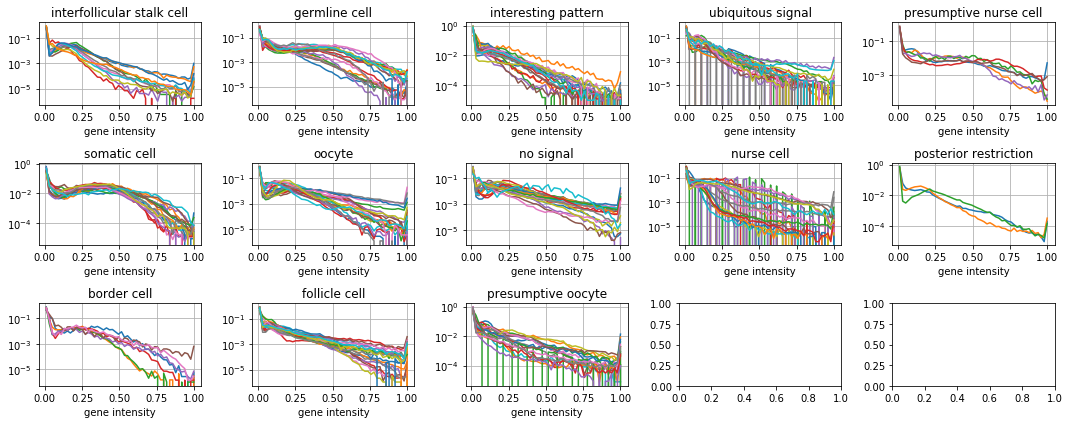

In [43]:
show_folder_histograms(d_hists_1, bins_1, nb_samples=20, nb_cols=5)

### Copy Images with double tag

In [34]:
PATH_IMAGES_OUT_2 = '/datagrid/Medical/microscopy/drosophila/TEMPORARY/annot-user-labels-2'

df_fuse_2 = df_fuse[df_fuse['label count'] == 2]
# print ('found: %i' % len(df_lb_2))
for idx, row in tqdm.tqdm(df_fuse_2.iterrows(), desc='images'):
    lbs = sorted([lb for lb in COL_LABEL_UQ if row[lb] == 1])
    path_lb = os.path.join(PATH_IMAGES_OUT_2, ' --- '.join(lbs))
    if not os.path.isdir(path_lb):
        os.mkdir(path_lb)
    p_img_in = os.path.join(PATH_IMAGES_IMGS, row['image_path'])
    p_img_out = os.path.join(path_lb, os.path.splitext(row['image_path'])[0] + '.png')
    if os.path.isfile(p_img_in) and not os.path.isfile(p_img_out):
        plt.imsave(p_img_out, plt.imread(p_img_in))
        # shutil.copy(p_img_in, p_img_out)

images: 9132it [00:07, 1145.73it/s]


In [38]:
l_dirs = [{'label': os.path.basename(p), 'count': len(glob.glob(os.path.join(p, '*')))} 
          for p in glob.glob(os.path.join(PATH_IMAGES_OUT_2, '*')) if os.path.isdir(p)]
df_dir_stat_2 = pd.DataFrame(l_dirs).set_index('label').sort_values('count', ascending=False)
df_dir_stat_2[df_dir_stat_2['count'] > 0][:25]

,count
label,
ubiquitous signal,8630
enrichment ubiquitous --- oocyte,4864
nurse cell,1881
oocyte --- posterior restriction,1213
follicle cell --- somatic cell,1066
anterior restriction --- oocyte,652
nurse cell --- ubiquitous signal,405
cytoplasmic foci --- nurse cell,283
interesting pattern,264


In [36]:
d_hists_2, bins_2 = compute_folder_histograms(PATH_IMAGES_OUT_2, df_dir_stat_2, path_segs=PATH_IMAGES_SEGS)

100%|██████████| 71/71 [16:16<00:00, 13.76s/it]  


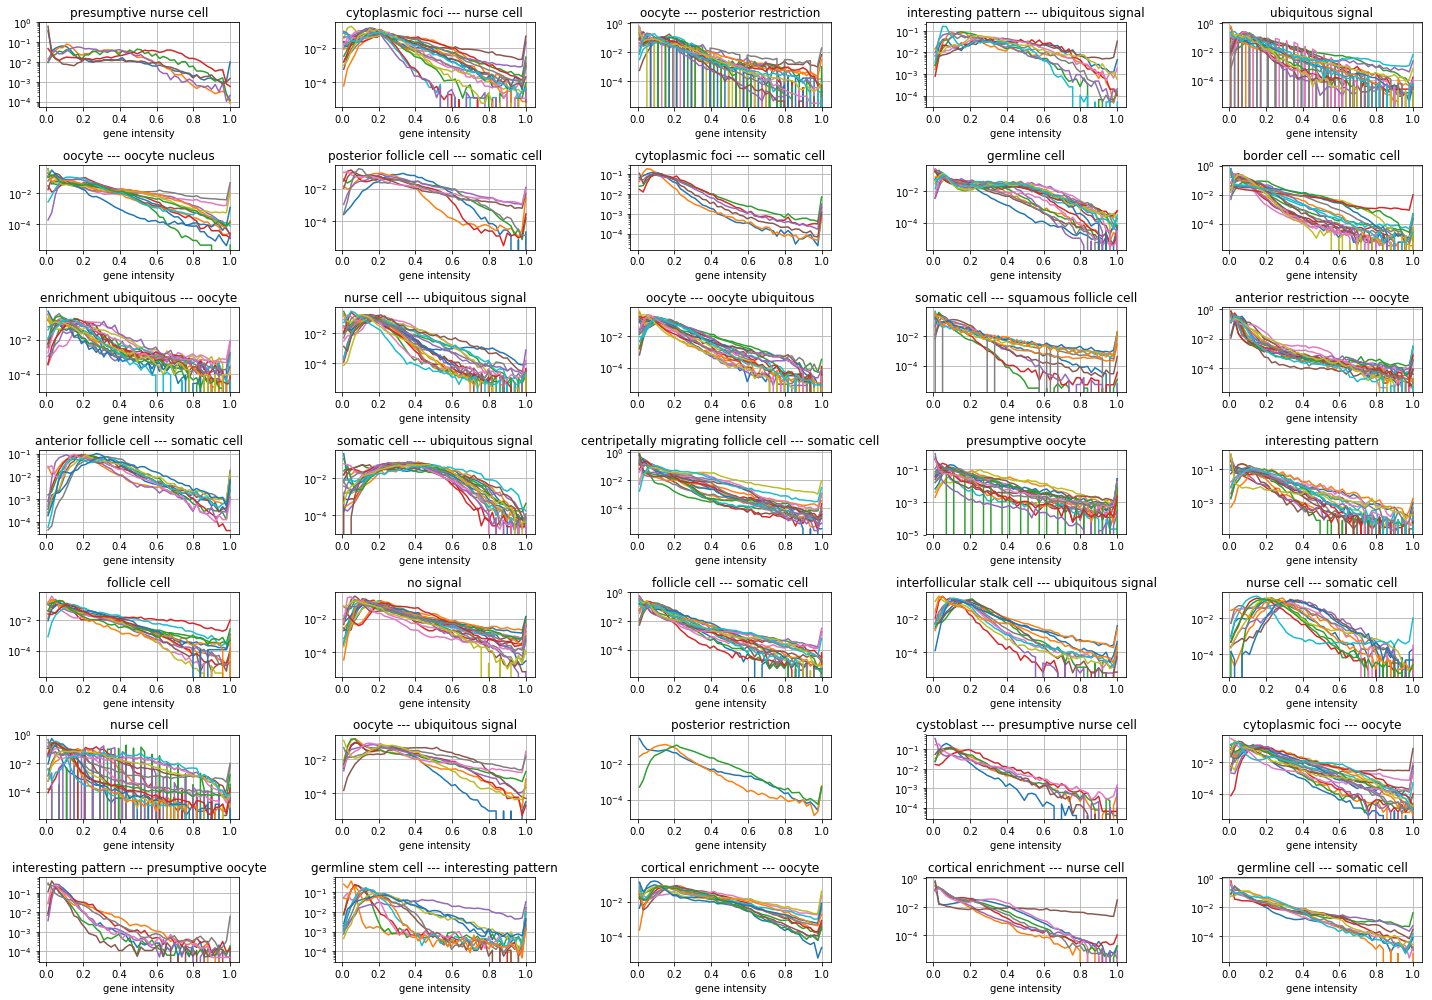

In [47]:
show_folder_histograms(d_hists_2, bins_2, nb_samples=20, nb_cols=5)